In [19]:
import numpy as np
import torch
from matplotlib import pyplot as plt

from src.datasets import CFMGraphDataset
from src.loaders import get_test_loader, get_train_loaders
from src.models import GATEncoder
from src.utils import predict, save
from betacal import BetaCalibration
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = GATEncoder(
    d_features=7,
    d_edges=5,
    d_out=24,
    d_hidden_dim=300,
    num_layers=3,
    num_heads=3,
    d_linear_layers=[256],
    dropout=0.01,
    activation="ReLU",
).to(device)

load = "runs/night_test"

In [21]:
labels = {}
probabilities = {}
predictions = {}

train_loader, val_loader = get_train_loaders(
    batch_size=128, shuffle=False, dataset=CFMGraphDataset
)
test_loader = get_test_loader(batch_size=128, dataset=CFMGraphDataset)
is_torch_geometric = True

model.load_state_dict(torch.load(f"{load}/model.pt"))

predictions["train"], labels["train"], probabilities["train"] = predict(
    model, train_loader, device, is_torch_geometric=is_torch_geometric
)
predictions["val"], labels["val"], probabilities["val"] = predict(
    model, val_loader, device, is_torch_geometric=is_torch_geometric
)
predictions["test"], _, probabilities["test"] = predict(
    model, test_loader, device, is_torch_geometric=is_torch_geometric
)

# We don't have labels for the test set
labels["test"] = predictions["test"]

100%|██████████| 638/638 [00:13<00:00, 46.73it/s]


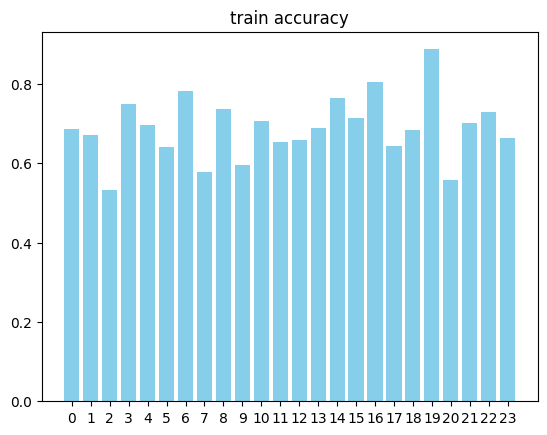

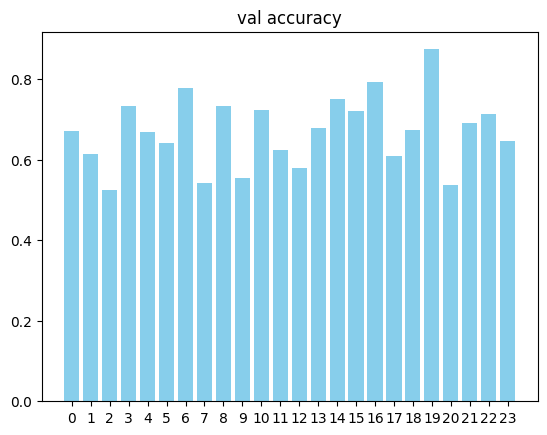

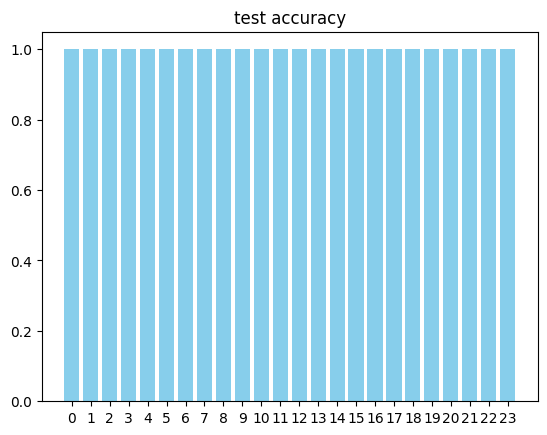

In [22]:
def ploy_accuracy(key):
    for i in range(24):
        plt.bar(
            i,
            np.mean(predictions[key][labels[key] == i] == i),
            color="skyblue",
        )
    plt.title(f"{key} accuracy")
    plt.xticks(range(24))
    plt.show()


ploy_accuracy("train")
ploy_accuracy("val")
ploy_accuracy("test")

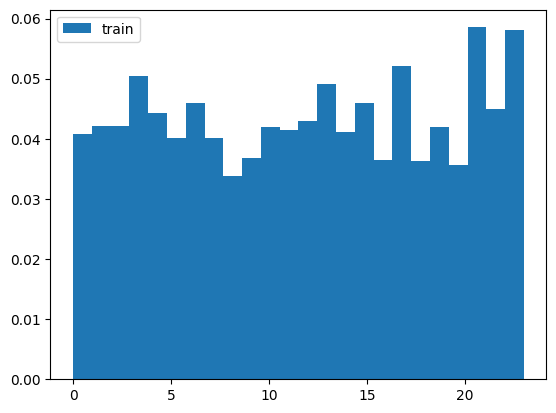

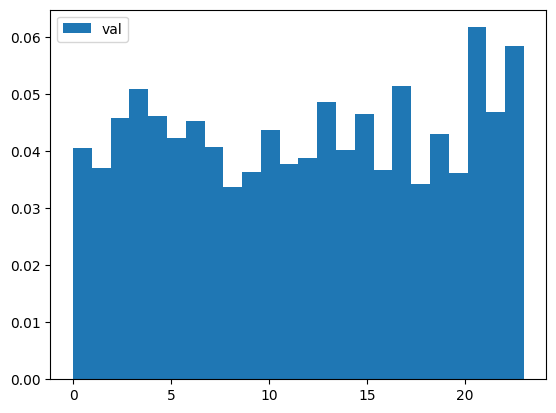

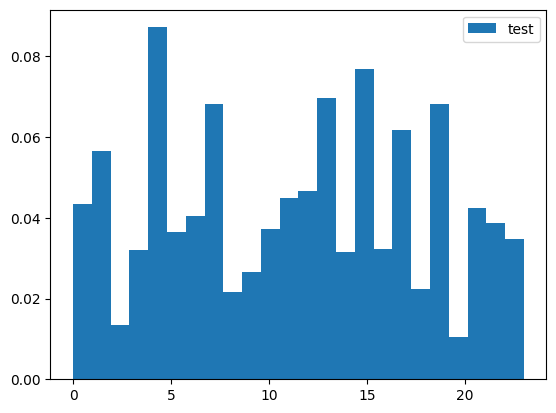

In [23]:
def plot_repartition(key):
    plt.hist(predictions[key], bins=24, label=key, density=True)
    plt.legend()
    plt.show()


plot_repartition("train")
plot_repartition("val")
plot_repartition("test")

In [24]:
cal_curves = {}


def compute_cal_graph(key, bins=10, strategy="uniform"):
    for i in range(24):
        cal_curves[f"{key}_fraction"], cal_curves[f"{key}_probabilities"] = (
            calibration_curve(
                labels[key] == i,
                probabilities[key][:, i],
                n_bins=bins,
                strategy=strategy,
            )
        )


compute_cal_graph("train")
compute_cal_graph("val")
compute_cal_graph("test")

In [25]:
regressors = {}


def calibrate(regressor, name):
    probabilities[f"train_{name}"] = np.zeros_like(probabilities["train"])
    probabilities[f"val_{name}"] = np.zeros_like(probabilities["val"])
    probabilities[f"test_{name}"] = np.zeros_like(probabilities["test"])

    for i in range(24):
        regressors[f"{name}_{i}"] = regressor
        regressors[f"{name}_{i}"].fit(
            probabilities["train"][:, i].reshape(-1, 1), (labels["train"] == i)
        )

        probabilities[f"train_{name}"][:, i] = regressors[f"{name}_{i}"].predict(
            probabilities["train"][:, i].reshape(-1, 1)
        )
        probabilities[f"val_{name}"][:, i] = regressors[f"{name}_{i}"].predict(
            probabilities["val"][:, i].reshape(-1, 1)
        )
        probabilities[f"test_{name}"][:, i] = regressors[f"{name}_{i}"].predict(
            probabilities["test"][:, i].reshape(-1, 1)
        )

    predictions[f"train_{name}"] = probabilities[f"train_{name}"].argmax(axis=1)
    predictions[f"val_{name}"] = probabilities[f"val_{name}"].argmax(axis=1)
    predictions[f"test_{name}"] = probabilities[f"test_{name}"].argmax(axis=1)

    labels[f"train_{name}"] = labels["train"]
    labels[f"val_{name}"] = labels["val"]
    labels[f"test_{name}"] = predictions[f"test_{name}"]


calibrate(IsotonicRegression(), "isotonic")

compute_cal_graph("train_isotonic")
compute_cal_graph("val_isotonic")
compute_cal_graph("test_isotonic")

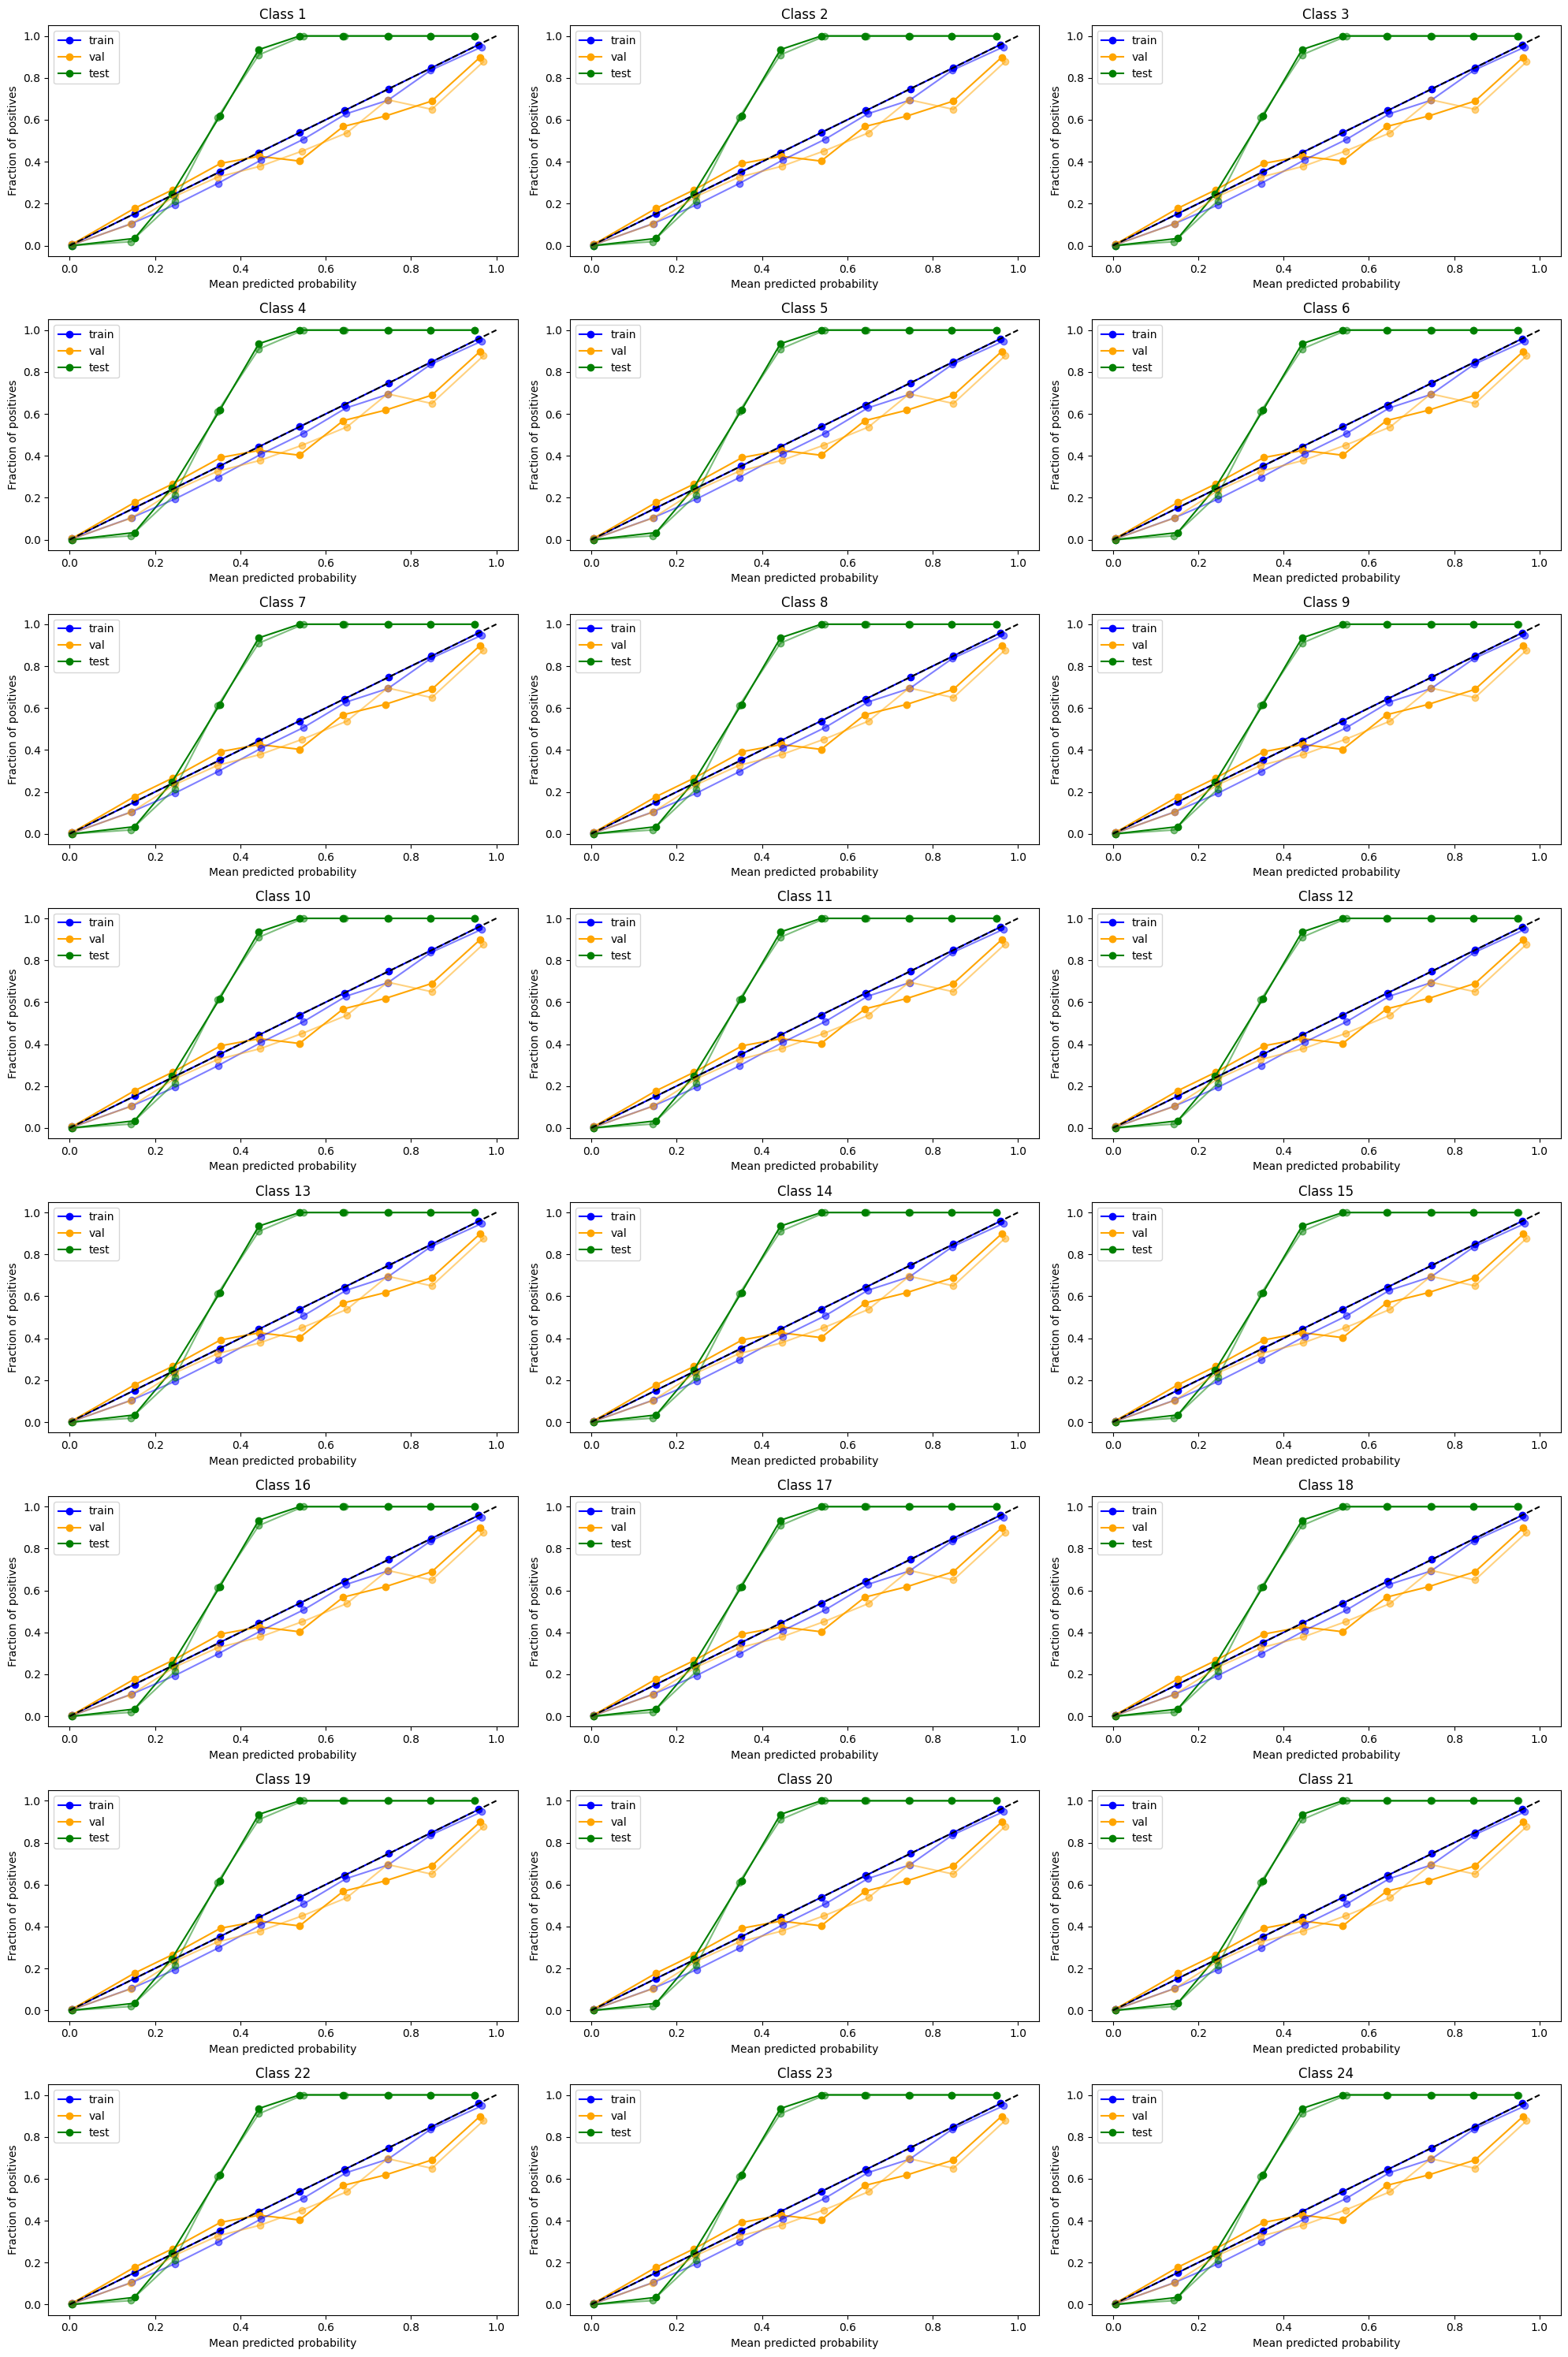

In [26]:
def plot_calibration(name, K=3):
    fig, ax = plt.subplots(24 // K, K, figsize=(20, 30))

    for i in range(24):
        ax[i // K, i % K].plot(
            cal_curves[f"train_{name}_probabilities"],
            cal_curves[f"train_{name}_fraction"],
            marker="o",
            label="train",
            color="blue",
        )
        ax[i // K, i % K].plot(
            cal_curves[f"val_{name}_probabilities"],
            cal_curves[f"val_{name}_fraction"],
            marker="o",
            label="val",
            color="orange",
        )
        ax[i // K, i % K].plot(
            cal_curves[f"test_{name}_probabilities"],
            cal_curves[f"test_{name}_fraction"],
            marker="o",
            label="test",
            color="green",
        )

        ax[i // K, i % K].plot(
            cal_curves["train_probabilities"],
            cal_curves["train_fraction"],
            marker="o",
            alpha=0.5,
            color="blue",
        )
        ax[i // K, i % K].plot(
            cal_curves["val_probabilities"],
            cal_curves["val_fraction"],
            marker="o",
            alpha=0.5,
            color="orange",
        )
        ax[i // K, i % K].plot(
            cal_curves["test_probabilities"],
            cal_curves["test_fraction"],
            marker="o",
            alpha=0.5,
            color="green",
        )
        ax[i // K, i % K].plot([0, 1], [0, 1], linestyle="--", color="black")
        ax[i // K, i % K].set_title(f"Class {i+1}")
        ax[i // K, i % K].set_xlabel("Mean predicted probability")
        ax[i // K, i % K].set_ylabel("Fraction of positives")
        ax[i // K, i % K].legend()

    fig.tight_layout()
    plt.show()


plot_calibration("isotonic")

In [28]:
save(
    predictions["test_isotonic"],
)